# What is the world eating?

In this notebook we apply CP to a [food consumption dataset from The Food and Agriculture Organization of the United Nations](https://www.kaggle.com/dorbicycle/world-foodfeed-production). The code for CP can be found in the `cp.jl` file if you are interested in a simple implementation, which follows the lectures.

This data is collected from 1961 to 2013, and the features are 

* the countries/areas.
* the food types.
* whether the food is used for feed or human food. We ignore feed for our analysis.
* consumption in unit of $1000$ tonnes.

To do tensor decomposition on the dataset, we need to convert it into a order-3 tensor $A$, the axes of which represent

1. the food types.
2. the countries/areas.
3. year.

We will do a rank-1 decomposition $A = x \otimes y \otimes z$, and see if the vectors make sense.

In [17]:
push!(LOAD_PATH, pwd())
using CSV, DataFrames
using cp
using Plots

In [20]:
df = CSV.File("fao.csv", header=1) |> DataFrame
# We will consider only food eaten by people.
filter!(row -> row[:Element] == "Food", df)
# Remove some duplicates in the data.
unique!(df, [:Item, :Area])

,Area Abbreviation,Area Code,Area,Item Code,Item
,String,Int64,String,Int64,String
1,AFG,2,Afghanistan,2511,Wheat and products
2,AFG,2,Afghanistan,2805,Rice (Milled Equivalent)
3,AFG,2,Afghanistan,2513,Barley and products
4,AFG,2,Afghanistan,2514,Maize and products
5,AFG,2,Afghanistan,2517,Millet and products
6,AFG,2,Afghanistan,2520,"Cereals, Other"
7,AFG,2,Afghanistan,2531,Potatoes and products
8,AFG,2,Afghanistan,2542,Sugar (Raw Equivalent)
9,AFG,2,Afghanistan,2543,"Sweeteners, Other"


We need to reorder the dataset into a tensor. We do this by unstacking the data by area into a matrix for each year. Then we can stack all the matrices into a tensor. For example, let's unstack the data from 1961 into a matrix.

In [19]:
y1961 = coalesce.(unstack(df[:, [:Area, :Item, :Y1961]], :Area, :Y1961), 0)

,Item,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda
,String,Int64,Int64,Int64,Int64,Int64
1,Alcoholic Beverages,0,13,96,128,0
2,Animal fats,20,8,14,2,0
3,Apples and products,14,10,33,0,0
4,"Aquatic Animals, Others",0,0,0,0,0
5,Aquatic Plants,0,0,0,0,0
6,"Aquatic Products, Other",0,0,0,0,0
7,Bananas,0,0,15,148,0
8,Barley and products,237,2,258,0,0
9,Beans,0,5,4,39,0


We can now do this for every year and stack them into a tensor.

In [21]:
year(x) = coalesce.(unstack(df[:, [:Area, :Item, Symbol(x)]], :Area, Symbol(x)), 0)
matrix_for_year(y::String) = Matrix{Float64}(year("Y$y")[:, 2:end])
n_prod, n_area = size(matrix_for_year("1961"))
ts = reshape(hcat([matrix_for_year(string(y)) for y = 1961:2013]...), (n_prod, n_area, (2013-1961+1)))

115×174×53 Array{Float64,3}:
[:, :, 1] =
    0.0   13.0    96.0  128.0  0.0  …  271.0   114.0  47.0  373.0  210.0
   20.0    8.0    14.0    2.0  0.0      14.0    20.0  14.0    1.0    3.0
   14.0   10.0    33.0    0.0  0.0      13.0     1.0   1.0    1.0    3.0
    0.0    0.0     0.0    0.0  0.0       0.0     0.0   0.0    0.0    0.0
    0.0    0.0     0.0    0.0  0.0       0.0     0.0   0.0    0.0    0.0
    0.0    0.0     0.0    0.0  0.0  …    0.0     0.0   0.0    0.0    0.0
    0.0    0.0    15.0  148.0  0.0     640.0   319.0  10.0    1.0   29.0
  237.0    2.0   258.0    0.0  0.0       2.0     0.0  70.0    0.0    0.0
    0.0    5.0     4.0   39.0  0.0      57.0    20.0   0.0    0.0   17.0
    0.0    9.0    91.0    9.0  0.0     241.0    85.0  46.0   15.0   12.0
    0.0    1.0     5.0   10.0  0.0  …   28.0    28.0   0.0    0.0    2.0
    0.0    0.0     0.0   41.0  0.0       0.0     0.0   0.0  358.0  195.0
   43.0    7.0    47.0   17.0  1.0     130.0    67.0  19.0   29.0   43.0
    ⋮     

In [22]:
u, v, w = cp_als(ts, 1, 40); # This can take half a minute.
u, v, w = (u[:, 1], v[:, 1], w[:, 1]);

## The world is eating more

$w$ represents the most pronounced trend of relative consumption of food. The plot below resembles those you see in the first slide of an agriculture talk.

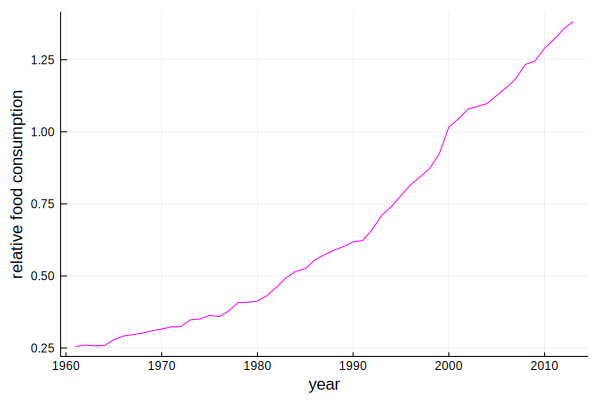

In [45]:
plot(1961:2013, w, xlabel="year", label="", ylabel="relative food consumption", color=:magenta)

## It's mostly veggies

People have been mostly vegetarian during the last half century.

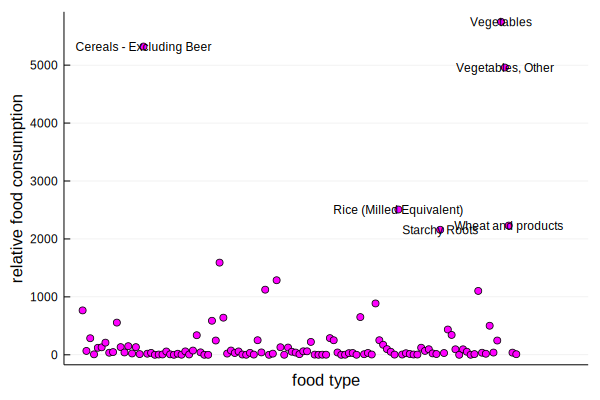

In [46]:
items = y1961[:, :Item]
significant_u = filter((entry) -> entry[2] > max(u...) / 3.0, collect(enumerate(u)))
scatter(u, xticks=[], xlabel="food type", xlim=[0, length(u)+15], label="", ylabel="relative food consumption", color=:magenta)
annotate!([(i, s, Plots.text(items[i], 8)) for (i, s) in significant_u])

## A few standout countries/areas

The consumption is roughly proportional to the population for each country/area. 

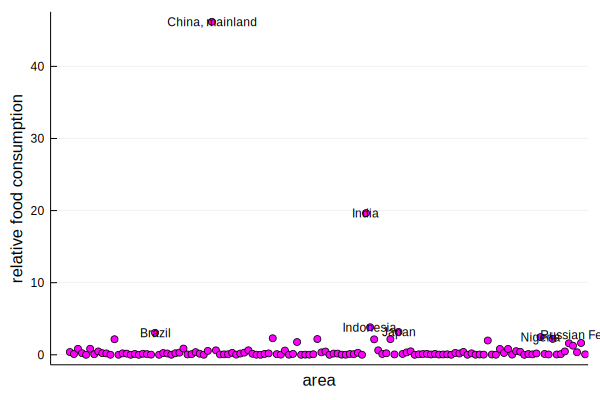

In [47]:
areas = [string(symbol) for symbol in names(y1961) if symbol !== :Item]
significant_v = filter((entry) -> entry[2] > max(v...) / 20.0, collect(enumerate(v)))
scatter(v, xticks=[], xlabel="area", xlim=[0, length(u)+10], label="", ylabel="relative food consumption", color=:magenta)
annotate!([(i, s, Plots.text(areas[i], 8)) for (i, s) in significant_v])